In [78]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [79]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [80]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
sns.set_context('poster')

In [82]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [83]:
df = pd.read_pickle('CCPA.pkl.gz')

In [84]:
dfc = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [85]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

In [86]:
d = cp.generate_decline(dfc, scale=False)
d = d.loc[d.day < 85]

In [87]:
train_df_orig, test_df_orig = cp.split_train_test(d,test_size=0.4)

In [91]:
train_df = cp.augment_training(train_df_orig)
train_df = train_df.loc[train_df.day <= 80]
test_df = cp.resample_df(test_df_orig, period='1d')
test_df = test_df.loc[test_df.day <= 80]

In [92]:
train_df.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,FL,augment_name,experiment_sample_orig
0,"e1, 10B, original_mean",e1,10B,C9B,DE,Co_Culture,0,4.951,original_mean,"e1, 10B"
1,"e1, 10B, original_mean",e1,10B,C9B,DE,Co_Culture,1,3.038,original_mean,"e1, 10B"
2,"e1, 10B, original_mean",e1,10B,C9B,DE,Co_Culture,2,NaN,original_mean,"e1, 10B"
3,"e1, 10B, original_mean",e1,10B,C9B,DE,Co_Culture,3,NaN,original_mean,"e1, 10B"
4,"e1, 10B, original_mean",e1,10B,C9B,DE,Co_Culture,4,2.803,original_mean,"e1, 10B"


In [93]:
X_train = cp.experiments2X(train_df, cumsummode=False, value_col='FL')
metadf_train = cp.get_meta(train_df)
metadf_train.index = metadf_train.experiment_sample

X_test = cp.experiments2X(test_df, cumsummode=False, value_col='FL')
metadf_test = cp.get_meta(test_df)
metadf_test.index = metadf_test.experiment_sample


In [94]:
y_train = metadf_train.PRO + ','+ metadf_train.ALT
y_test = metadf_test.PRO + ','+ metadf_test.ALT


In [95]:
clf = cp.forest_classifier(X=X_train, y=y_train)
r = cp.score_model('', clf, X_train, y_train, X_test, y_test, return_y=True)


train score 1.0
oob score 1.0


In [96]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12300, 81), (12300,), (138, 81), (138,))

In [97]:
(clf, res, y_df) = r

In [98]:
res

{'model': '',
 'n_features': 81,
 'orig_n_features': 81,
 'accuracy_train': 1.0,
 'precision_train': 1.0,
 'recall_train': 1.0,
 'f1_train': 1.0,
 'support_train': None,
 'accuracy_test': 0.8260869565217391,
 'precision_test': 0.8297527706734867,
 'recall_test': 0.8260869565217391,
 'f1_test': 0.8236487959028004,
 'support_test': None}

In [99]:
y_df.head()

,_y,_y_PRO,_y_pred,_y_pred_PRO,Type
experiment_sample,,,,,
"e1, 10B, FL_0.05_0_first","C9B,DE",C9B,"C9B,DE",C9B,Train
"e1, 10B, FL_0.05_0_last","C9B,DE",C9B,"C9B,DE",C9B,Train
"e1, 10B, FL_0.05_0_max","C9B,DE",C9B,"C9B,DE",C9B,Train
"e1, 10B, FL_0.05_0_mean","C9B,DE",C9B,"C9B,DE",C9B,Train
"e1, 10B, FL_0.05_0_median","C9B,DE",C9B,"C9B,DE",C9B,Train


accuracy: 0.47101449275362317
              precision    recall  f1-score   support

     C9B,1A3       0.80      0.67      0.73         6
    C9B,ATCC       0.00      0.00      0.00         2
    C9B,BS11       0.40      0.67      0.50         6
      C9B,DE       0.75      0.50      0.60         6
     C9B,DE1       0.57      0.67      0.62         6
    MED4,1A3       0.50      0.60      0.55         5
   MED4,ATCC       0.50      0.60      0.55         5
   MED4,BS11       0.33      0.20      0.25         5
     MED4,DE       0.36      0.67      0.47         6
    MED4,DE1       0.25      0.17      0.20         6
 MIT9312,1A3       0.57      0.67      0.62         6
MIT9312,ATCC       1.00      0.40      0.57         5
MIT9312,BS11       0.67      0.33      0.44         6
  MIT9312,DE       0.50      0.33      0.40         6
 MIT9312,DE1       0.40      0.40      0.40         5
 MIT9313,1A3       0.43      0.60      0.50         5
MIT9313,ATCC       1.00      0.80      0.89        

C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


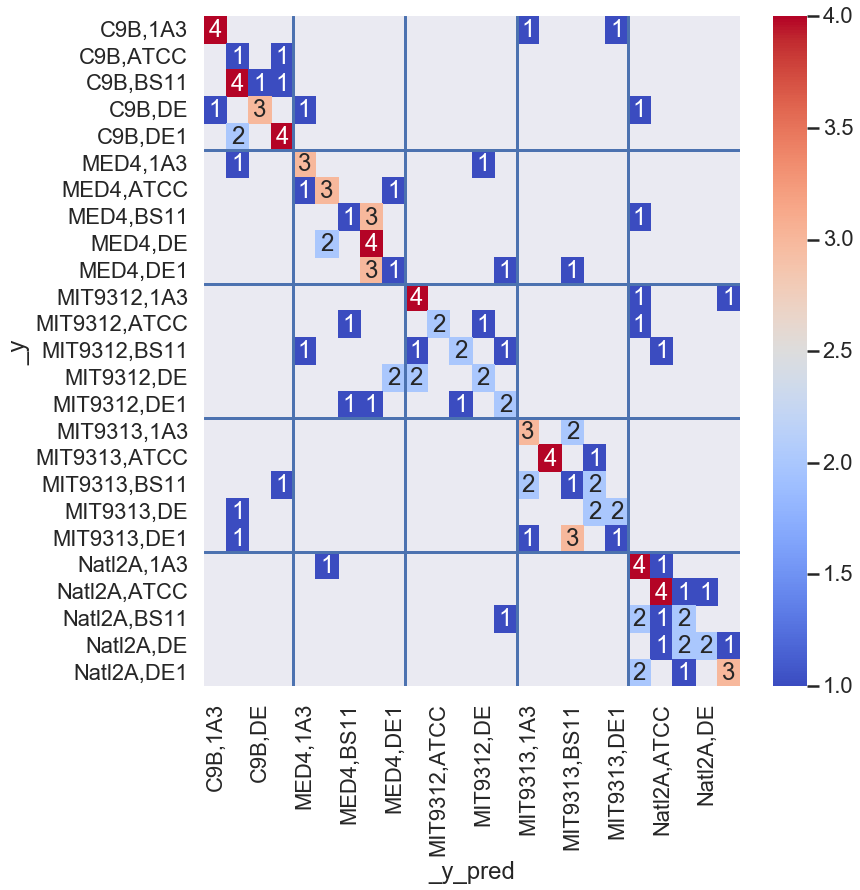

In [100]:
    from sklearn.metrics import classification_report, accuracy_score
    
    t = y_df.loc[y_df.Type == 'Test'].pivot_table(index='_y', columns=['_y_pred'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df.loc[y_df.Type == 'Test']['_y'], y_pred=y_df.loc[y_df.Type == 'Test']['_y_pred'])}")
    print(classification_report(y_true=y_df.loc[y_df.Type == 'Test']['_y'], y_pred=y_df.loc[y_df.Type == 'Test']['_y_pred']))

    #forest_feature_importance(clf, X.columns)
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(t, annot=True, cmap='coolwarm', ax=ax)
    ax.axhline(5)
    ax.axhline(15)
    ax.axhline(20)
    ax.axhline(10)
    ax.axvline(4)
    ax.axvline(9)
    ax.axvline(14)
    ax.axvline(19)
#    sns.heatmap(t, annot=True, cmap='coolwarm')


accuracy: 0.8260869565217391
              precision    recall  f1-score   support

         C9B       0.85      0.85      0.85        26
        MED4       0.73      0.81      0.77        27
     MIT9312       0.86      0.64      0.73        28
     MIT9313       0.89      0.89      0.89        27
      Natl2A       0.82      0.93      0.87        30

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.82       138
weighted avg       0.83      0.83      0.82       138



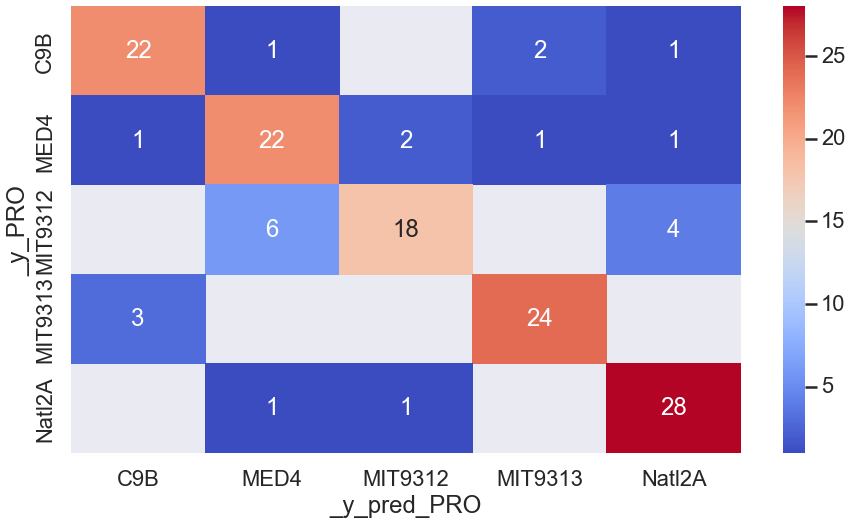

In [101]:
    from sklearn.metrics import classification_report, accuracy_score
    
    t = y_df.loc[y_df.Type == 'Test'].pivot_table(index='_y_PRO', columns=['_y_pred_PRO'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df.loc[y_df.Type == 'Test']['_y_PRO'], y_pred=y_df.loc[y_df.Type == 'Test']['_y_pred_PRO'])}")
    print(classification_report(y_true=y_df.loc[y_df.Type == 'Test']['_y_PRO'], y_pred=y_df.loc[y_df.Type == 'Test']['_y_pred_PRO']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


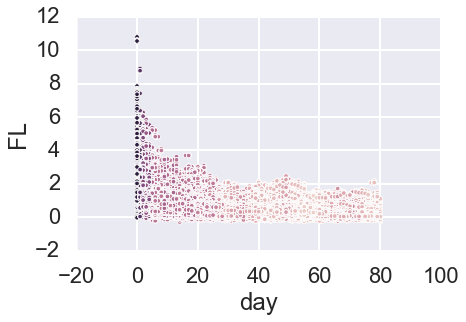

In [102]:
feature_importances = pd.DataFrame(clf.feature_importances_, #clf.estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
mergedf = train_df.merge(feature_importances, left_on='day', right_index=True, how='left')
mergedf.head()
sns.relplot(data=mergedf, x='day', y='FL', hue='importance', legend=None, aspect=1.4)

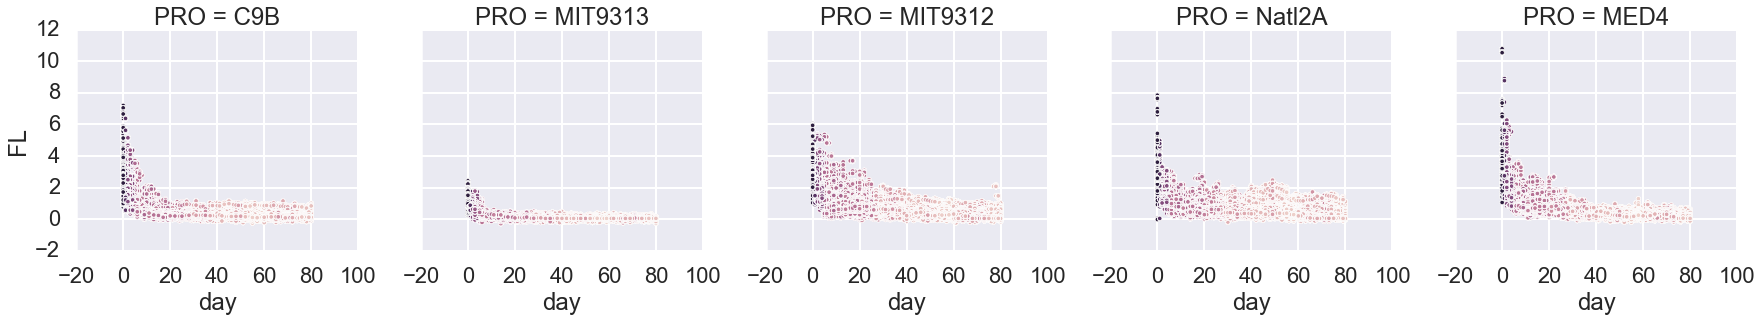

In [103]:
sns.relplot(data=mergedf, x='day', y='FL', hue='importance', legend=None, col='PRO')

In [104]:
y_train = metadf_train.PRO 
y_test = metadf_test.PRO 


In [105]:
clf = cp.forest_classifier(X=X_train, y=y_train)
r = cp.score_model('', clf, X_train, y_train, X_test, y_test, return_y=True)


train score 1.0
oob score 1.0


In [106]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12300, 81), (12300,), (138, 81), (138,))

In [107]:
(clf, res, y_df) = r

In [108]:
res

{'model': '',
 'n_features': 81,
 'orig_n_features': 81,
 'accuracy_train': 1.0,
 'precision_train': 1.0,
 'recall_train': 1.0,
 'f1_train': 1.0,
 'support_train': None,
 'accuracy_test': 0.8188405797101449,
 'precision_test': 0.8242277529234051,
 'recall_test': 0.8188405797101449,
 'f1_test': 0.8170743448512111,
 'support_test': None}

In [109]:
y_df.head()

,_y,_y_PRO,_y_pred,_y_pred_PRO,Type
experiment_sample,,,,,
"e1, 10B, FL_0.05_0_first",C9B,C9B,C9B,C9B,Train
"e1, 10B, FL_0.05_0_last",C9B,C9B,C9B,C9B,Train
"e1, 10B, FL_0.05_0_max",C9B,C9B,C9B,C9B,Train
"e1, 10B, FL_0.05_0_mean",C9B,C9B,C9B,C9B,Train
"e1, 10B, FL_0.05_0_median",C9B,C9B,C9B,C9B,Train


accuracy: 0.8188405797101449
              precision    recall  f1-score   support

         C9B       0.83      0.96      0.89        26
        MED4       0.77      0.74      0.75        27
     MIT9312       0.86      0.68      0.76        28
     MIT9313       0.92      0.85      0.88        27
      Natl2A       0.74      0.87      0.80        30

    accuracy                           0.82       138
   macro avg       0.83      0.82      0.82       138
weighted avg       0.82      0.82      0.82       138



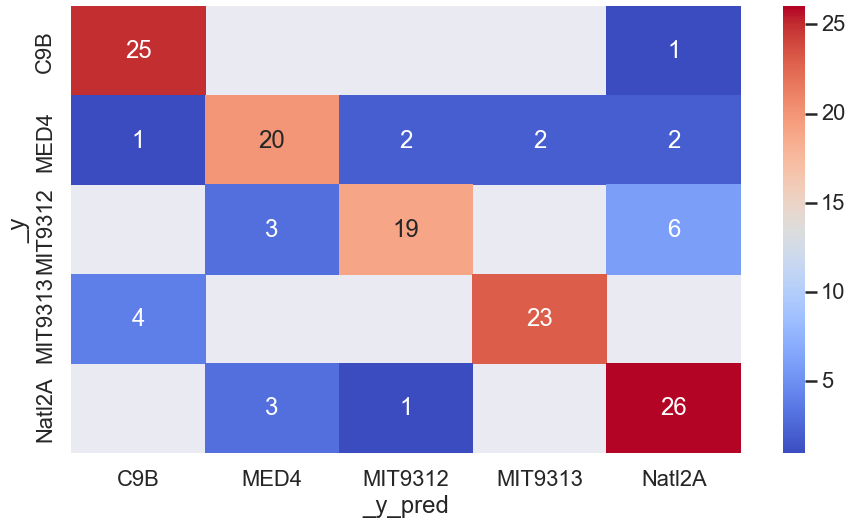

In [110]:
    from sklearn.metrics import classification_report, accuracy_score
    
    t = y_df.loc[y_df.Type == 'Test'].pivot_table(index='_y', columns=['_y_pred'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df.loc[y_df.Type == 'Test']['_y'], y_pred=y_df.loc[y_df.Type == 'Test']['_y_pred'])}")
    print(classification_report(y_true=y_df.loc[y_df.Type == 'Test']['_y'], y_pred=y_df.loc[y_df.Type == 'Test']['_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


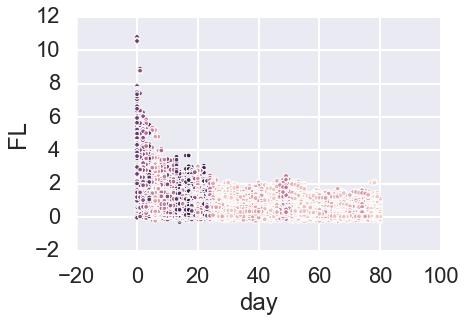

In [111]:
feature_importances = pd.DataFrame(clf.feature_importances_, #clf.estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
mergedf = train_df.merge(feature_importances, left_on='day', right_index=True, how='left')
mergedf.head()
sns.relplot(data=mergedf, x='day', y='FL', hue='importance', legend=None, aspect=1.4)

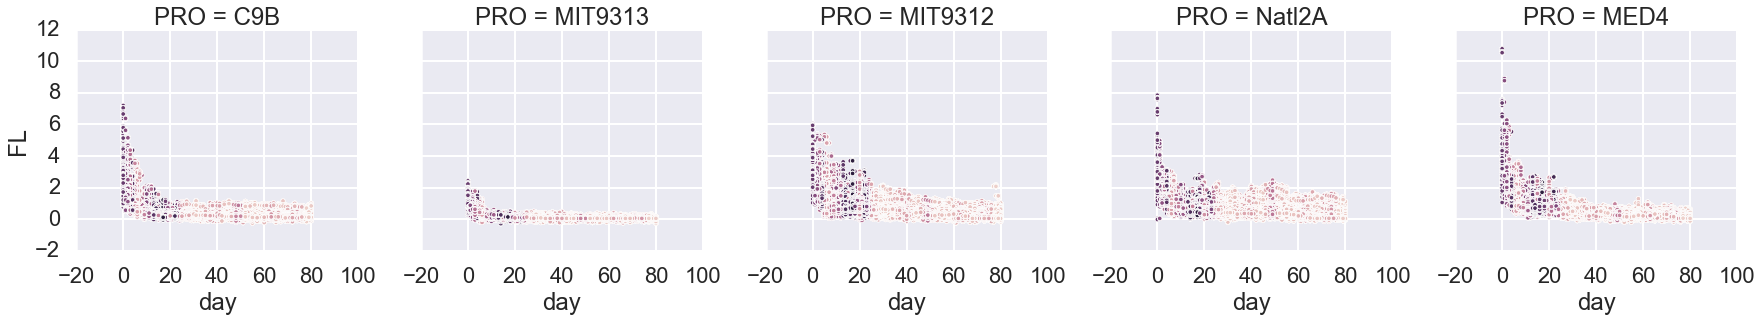

In [112]:
sns.relplot(data=mergedf, x='day', y='FL', hue='importance', legend=None, col='PRO')

In [113]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], 1, trainy.nunique()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
#run_experiment()

In [114]:
X_train_keras = np.expand_dims(np.array(X_train.values), axis=3).astype(np.float32)

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


In [115]:
X_test_keras = np.expand_dims(np.array(X_test.values), axis=3).astype(np.float32)

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


In [116]:
from sklearn.preprocessing import LabelBinarizer
# convert the labels from integers to vectors (for 2-class, binary
# classification you should use Keras' to_categorical function
# instead as the scikit-learn's LabelBinarizer will not return a
# vector)
lb = LabelBinarizer()
y_train_keras = lb.fit_transform(y_train)
y_test_keras = lb.transform(y_test)

# y_test_keras_df = pd.get_dummies(y_test)
# y_test_keras = y_test_keras_df.values.astype(np.float32)

In [117]:
    verbose, epochs, batch_size = 1, 10, 32
    n_timesteps, n_features, n_outputs = X_train_keras.shape[1], X_train_keras.shape[2], y_train_keras.shape[1]
    n_timesteps, n_features, n_outputs 
    model = Sequential()
    model.add(Conv1D(filters=100, kernel_size=10, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=100, kernel_size=10, activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [118]:
    # fit network
    H = model.fit(X_train_keras, y_train_keras, epochs=epochs, batch_size=batch_size, verbose=verbose,
                 validation_data=(X_test_keras, y_test_keras))
#     # evaluate model
#     _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
#     return accuracy

Train on 12300 samples, validate on 138 samples
Epoch 1/10
12300/12300 [==============================] - 19s 2ms/step - loss: 0.2454 - acc: 0.9098 - val_loss: 0.5842 - val_acc: 0.8551
Epoch 2/10
12300/12300 [==============================] - 17s 1ms/step - loss: 0.0352 - acc: 0.9884 - val_loss: 1.0167 - val_acc: 0.7826
Epoch 3/10
12300/12300 [==============================] - 18s 1ms/step - loss: 0.0162 - acc: 0.9948 - val_loss: 0.8659 - val_acc: 0.8261
Epoch 4/10
12300/12300 [==============================] - 20s 2ms/step - loss: 0.0215 - acc: 0.9937 - val_loss: 0.8579 - val_acc: 0.8623
Epoch 5/10
12300/12300 [==============================] - 18s 1ms/step - loss: 0.0093 - acc: 0.9968 - val_loss: 1.3207 - val_acc: 0.8261
Epoch 6/10
12300/12300 [==============================] - 17s 1ms/step - loss: 0.0187 - acc: 0.9945 - val_loss: 0.9153 - val_acc: 0.8478
Epoch 7/10
12300/12300 [==============================] - 19s 2ms/step - loss: 0.0177 - acc: 0.9941 - val_loss: 1.0899 - val_acc: 

In [119]:
model.evaluate(X_train_keras, y_train_keras, batch_size=batch_size, verbose=1)

12300/12300 [==============================] - 7s 572us/step


[0.0012956168095249038, 0.9995121951219512]

In [120]:
model.evaluate(X_test_keras, y_test_keras, batch_size=batch_size, verbose=1)

138/138 [==============================] - 0s 564us/step


[1.4406734048456387, 0.8188405814378158]

In [121]:
from sklearn.metrics import classification_report
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(X_test_keras, batch_size=32)
print(classification_report(y_test_keras.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

         C9B       0.81      0.96      0.88        26
        MED4       0.74      0.74      0.74        27
     MIT9312       0.87      0.71      0.78        28
     MIT9313       0.89      0.89      0.89        27
      Natl2A       0.80      0.80      0.80        30

    accuracy                           0.82       138
   macro avg       0.82      0.82      0.82       138
weighted avg       0.82      0.82      0.82       138



In [122]:
predictions.argmax(axis=1)

array([0, 1, 1, 2, 3, 4, 0, 1, 1, 3, 3, 2, 4, 1, 1, 0, 0, 1, 3, 3, 2, 4,
       4, 4, 0, 2, 2, 4, 0, 1, 3, 3, 2, 4, 0, 2, 4, 4, 0, 1, 4, 2, 4, 0,
       1, 3, 3, 2, 4, 3, 4, 2, 4, 0, 1, 3, 2, 2, 4, 4, 0, 3, 2, 4, 0, 4,
       1, 2, 4, 1, 0, 4, 0, 1, 3, 2, 2, 4, 0, 2, 4, 4, 0, 1, 2, 4, 2, 3,
       3, 3, 1, 0, 0, 3, 3, 3, 0, 1, 4, 4, 3, 1, 0, 1, 3, 2, 4, 0, 0, 0,
       1, 3, 0, 1, 2, 0, 0, 0, 4, 3, 3, 1, 2, 4, 4, 1, 0, 3, 3, 1, 3, 0,
       0, 1, 1, 0, 2, 1], dtype=int64)

In [123]:
h_df = pd.DataFrame(data=H.history)

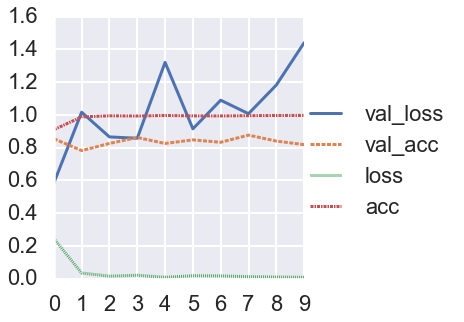

In [124]:
sns.relplot(data=h_df, kind='line')